Please go through the "building_strategies" notebook before looking at this notebook.

Lets work on optimizing our strategy parameters for the Bollinger Band&copy; we previously built.  We will include a function from the examples folder called build_example_strategy which builds this strategy.

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed") # ignore pesky warning, see https://github.com/numpy/numpy/pull/432

import pandas as pd
import numpy as np
import pyqstrat as pq
from pyqstrat.examples.build_example_strategy import build_example_strategy
from pyqstrat.evaluator import compute_sharpe, compute_sortino, compute_maxdd_pct, compute_amean, compute_rolling_dd



Lets try to optimize the the lookback period for the moving average and the number of standard deviations for the bands.

We will try to optimize the sharpe ratio but also look at the sortino and max drawdown as we optimize the sharpe.

To do this, we have to write a generator function and a cost function.  The generator produces all the combinations of parameters you want to optimize.  The cost function will run the strategy for each parameter combination provided by the generator and return whatever metric you want to optimize, as well as any other metrics you want to see at the same time.

In this case, our cost metric will be the sharpe ratio of the strategy but we will also look at sortino and drawdowns at the same time.

The optimizer uses multiple processes to run as fast as possible.  You can set the number of processes you want to use using the max_processes argument to the Optimizer constructor.  If you don't set this, the optimizer will the same number of processes as the CPU cores on your machine.  You may want to increase this number if your backtesting is I/O bound, and the CPU cores are often idle waiting for disk or other resources.

In this case, we are optimizing 2 parameters at the same time, but we can optimize 1 parameter or more than 2 as well.

<Figure size 432x288 with 0 Axes>

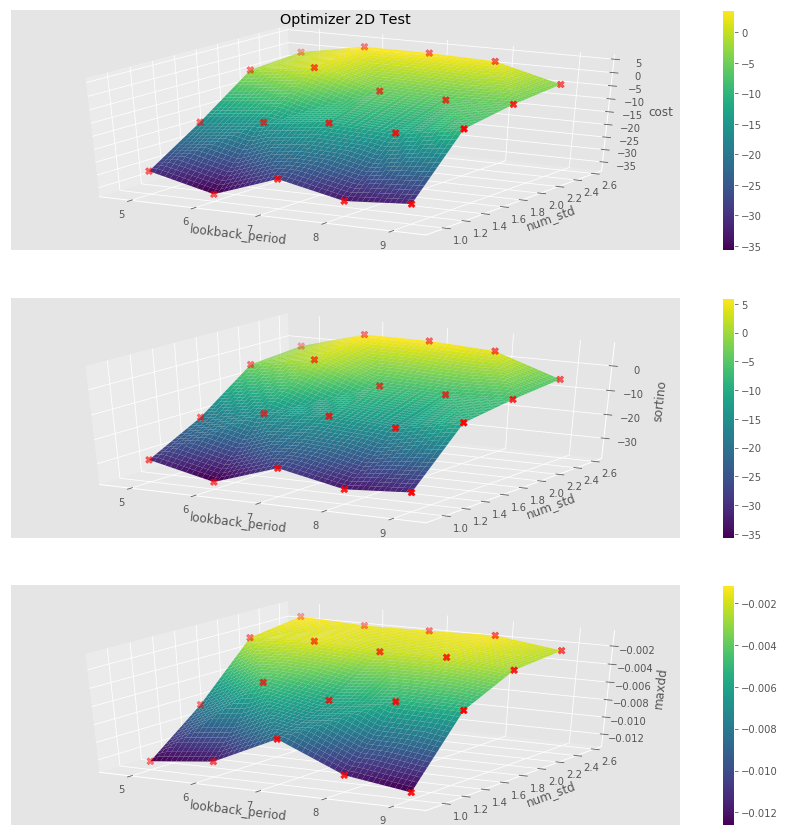

In [2]:
def generator():
    for lookback_period in np.arange(5, 10): 
        for num_std in np.arange(1, 3, 0.5): # number of standard deviations the bands are away from the SMA
            costs = (yield {'lookback_period' : lookback_period, 'num_std' : num_std})
            yield
            
def cost_func(suggestion):
    lookback_period, num_std = suggestion['lookback_period'], suggestion['num_std']
    
    strategy = build_example_strategy(lookback_period = lookback_period, num_std = num_std)
    
    portfolio = pq.Portfolio()
    portfolio.add_strategy('bb_strategy', strategy)
    
    portfolio.run()
    
    returns_df = strategy.df_returns()
    
    returns = returns_df.ret.values
    equity = returns_df.equity.values
    dates = returns_df.index.values
    
    amean = compute_amean(returns)
    sharpe = compute_sharpe(returns, amean, 252)
    sortino = compute_sortino(returns, amean, 252)
    rolling_dd = compute_rolling_dd(dates, equity)
    maxdd = compute_maxdd_pct(rolling_dd)
    
    return sharpe, {'sortino' : sortino, 'maxdd' : maxdd}

optimizer = pq.Optimizer('example', generator(), cost_func, max_processes = 1)
optimizer.run(raise_on_error = True)

optimizer.plot_3d(x = 'lookback_period', y = 'num_std', plot_type = 'surface');
    

There seems to be a region around a lookback period of 6 bars and 2.4 standard deviations that has a positive sharpe and sortino.  The actual points you provided to the plot are shown with red X markers.

Lets do a contour plot to see the same data in a different view.  We change the hspace to 0.25 so we can have more vertical space between the subplots to read titles

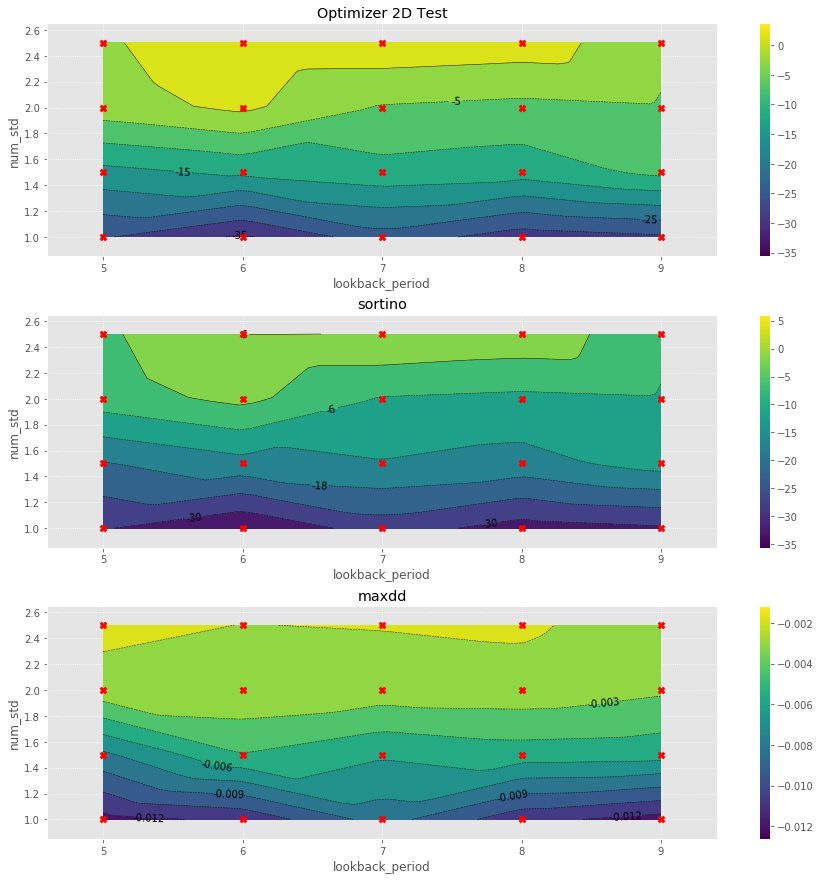

In [3]:
optimizer.plot_3d(x = 'lookback_period', y = 'num_std', plot_type = 'contour', hspace = 0.25);

Lets look at the actual values of the sharpes, sortinos and drawdowns

In [4]:
optimizer.df_experiments(ascending = False)

,lookback_period,num_std,cost,sortino,maxdd
0,6,2.5,3.665,6.101,-0.001522
9,7,2.5,3.545,5.921,-0.001437
12,8,2.5,2.715,4.317,-0.001271
3,6,2,1.072,1.624,-0.001693
1,5,2.5,-0.6606,-1.002,-0.001163
2,5,2,-2.134,-2.812,-0.001983
17,9,2.5,-3.613,-4.512,-0.002249
10,7,2,-5.394,-6.371,-0.002159
18,9,2,-5.437,-6.464,-0.002751
14,8,2,-6.304,-7.307,-0.002065


In [5]:
optimizer.df_experiments(sort_column = 'maxdd', ascending = False)

,lookback_period,num_std,cost,sortino,maxdd
1,5,2.5,-0.6606,-1.002,-0.001163
12,8,2.5,2.715,4.317,-0.001271
9,7,2.5,3.545,5.921,-0.001437
0,6,2.5,3.665,6.101,-0.001522
3,6,2,1.072,1.624,-0.001693
2,5,2,-2.134,-2.812,-0.001983
14,8,2,-6.304,-7.307,-0.002065
10,7,2,-5.394,-6.371,-0.002159
17,9,2.5,-3.613,-4.512,-0.002249
18,9,2,-5.437,-6.464,-0.002751


This confirms that lookback period somewhere around 5 or 6 bars with 2.5 standard deviations gives us a positive sharpe and sortino and lower drawdowns.  This is a toy example, and in real life you would want to run with a lot more data, look at the stability of this region and do other out of sample testing before you can use these with real money.